Below is the code for a kaggle competition that is ongoing 

In [2]:
'''Import the packages needed to run'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from scipy.stats import normaltest
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [3]:
'''Pull all the data from the .csv files into dataframes'''
supplement_clinical_data=pd.read_csv('supplemental_clinical_data.csv')
train_clinical_data=pd.read_csv('train_clinical_data.csv')
train_peptides=pd.read_csv('train_peptides.csv')
train_proteins=pd.read_csv('train_proteins.csv')

In [4]:
supplement_clinical_data=pd.DataFrame(supplement_clinical_data)
train_clinical_data=pd.DataFrame(train_clinical_data)
train_peptides=pd.DataFrame(train_peptides)
train_proteins=pd.DataFrame(train_proteins)

EXPLORATORY DATA ANALYSIS

Below is the length of each of the datasets for the competition:

In [7]:
print("The length of the train_clinical_data is: ",len(train_clinical_data))
print("The length of the train_peptides is: ",len(train_peptides))
print("The length of the train_proteins is: ",len(train_proteins))
print("The length of the supplement_clinical_data is: ",len(supplement_clinical_data))

The length of the train_clinical_data is:  2615
The length of the train_peptides is:  981834
The length of the train_proteins is:  232741
The length of the supplement_clinical_data is:  2223


Lets begin with the smaller dataset in this case the supplement_clinical_data dataset:

train_clinical_data.csv

visit_id - ID code for the visit.

visit_month - The month of the visit, relative to the first visit by the patient.

patient_id - An ID code for the patient.

updrs_[1-4] - The patient's score for part N of the Unified Parkinson's Disease Rating Scale. Higher numbers indicate more severe symptoms. Each 
sub-section covers a distinct category of symptoms, such as mood and behavior for Part 1 and motor functions for Part 3.


upd23b_clinical_state_on_medication - Whether or not the patient was taking medication such as Levodopa during the UPDRS assessment. Expected to mainly affect the scores for Part 3 (motor function). These medications wear off fairly quickly (on the order of one day) so it's common for patients to take the motor function exam twice in a single month, both with and without medication.



supplemental_clinical_data.csv Clinical records without any associated CSF samples. This data is intended to provide additional context about the typical progression of Parkinsons. Uses the same columns as train_clinical_data.csv.


Since train_clinical_data & supplement_clinical_data have the same columns lets check the information on them:

In [8]:
print('train_clinical_data Information on columns:\n',train_clinical_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             2615 non-null   object 
 1   patient_id                           2615 non-null   int64  
 2   visit_month                          2615 non-null   int64  
 3   updrs_1                              2614 non-null   float64
 4   updrs_2                              2613 non-null   float64
 5   updrs_3                              2590 non-null   float64
 6   updrs_4                              1577 non-null   float64
 7   upd23b_clinical_state_on_medication  1288 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 163.6+ KB
train_clinical_data Information on columns:
 None


In [9]:
print('supplement_clinical_data Information on columns:\n',supplement_clinical_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2223 entries, 0 to 2222
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             2223 non-null   object 
 1   patient_id                           2223 non-null   int64  
 2   visit_month                          2223 non-null   int64  
 3   updrs_1                              2010 non-null   float64
 4   updrs_2                              2009 non-null   float64
 5   updrs_3                              2218 non-null   float64
 6   updrs_4                              1295 non-null   float64
 7   upd23b_clinical_state_on_medication  1122 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 139.1+ KB
supplement_clinical_data Information on columns:
 None


Information on train_peptides file

In [10]:
print('train_peptides Information on columns:\n',train_peptides.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981834 entries, 0 to 981833
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   visit_id          981834 non-null  object 
 1   visit_month       981834 non-null  int64  
 2   patient_id        981834 non-null  int64  
 3   UniProt           981834 non-null  object 
 4   Peptide           981834 non-null  object 
 5   PeptideAbundance  981834 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 44.9+ MB
train_peptides Information on columns:
 None


Information on train_proteins files

In [11]:
print('train_proteins Information on columns:\n',train_proteins.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232741 entries, 0 to 232740
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   visit_id     232741 non-null  object 
 1   visit_month  232741 non-null  int64  
 2   patient_id   232741 non-null  int64  
 3   UniProt      232741 non-null  object 
 4   NPX          232741 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 8.9+ MB
train_proteins Information on columns:
 None


Since these two dataframes are identical in terms of col names lets combine them into a single dataframe, however the supplement_clinical_dataframe contains the clincial data relative to a given patient with respect to a particular medication without the CSF values while the train_clinical_data contains the CSF values.

Currently the CSF values are an important factor in understanding the progression PD of the patient, CSF is the Cerebral Spinal Fluid.



In [12]:
all_trained_clinical_data=pd.concat([train_clinical_data,supplement_clinical_data]).reset_index(drop=True)
all_trained_clinical_data.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [13]:
# The following is the length of the all_trained_clinical_data
print('The length of the all_trained_clinical_data is:', len(all_trained_clinical_data))

# The following is the number unique number or total number of patients removing the duplicates
print("The number of unique patients is: {:,d}".format(all_trained_clinical_data['patient_id'].nunique()))


The length of the all_trained_clinical_data is: 4838
The number of unique patients is: 1,019


In [14]:
'''Null values are being visualized below'''

# This extracts the null numbers per row from the dataframe and puts it in a new column
train_clinical_data['nullCount']=train_clinical_data.isnull().sum(axis=1)

# Now lets look at the null values by grouping them 
nullCount_train_clinical_data = train_clinical_data.groupby('nullCount')['visit_id'].count().to_dict()



In [15]:
nullCount_train_clinical_data 

{0: 1259, 1: 331, 2: 1014, 3: 10, 4: 1}

In [16]:
null_train_clinical_data = {"{} Null Value(s)".format(k) : v for k, v in nullCount_train_clinical_data.items()} 
print(null_train_clinical_data)

{'0 Null Value(s)': 1259, '1 Null Value(s)': 331, '2 Null Value(s)': 1014, '3 Null Value(s)': 10, '4 Null Value(s)': 1}


In [16]:
print(train_peptides.head())

#Peptide information
peptide_list=train_peptides['Peptide'].unique()
n_peptide_list=train_peptides['Peptide'].nunique()
print("Unique number of peptides: %d"%n_peptide_list)

# Protein information
protein_list=train_peptides['UniProt'].unique()
n_protein_list=train_peptides['UniProt'].nunique()
print("Unique number of proteins: %d"%n_protein_list)

  visit_id  visit_month  patient_id UniProt  \
0     55_0            0          55  O00391   
1     55_0            0          55  O00533   
2     55_0            0          55  O00533   
3     55_0            0          55  O00533   
4     55_0            0          55  O00533   

                                  Peptide  PeptideAbundance  
0                           NEQEQPLGQWHLS           11254.3  
1                             GNPEPTFSWTK          102060.0  
2                         IEIPSSVQQVPTIIK          174185.0  
3  KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK           27278.9  
4                            SMEQNGPGLEYR           30838.7  
Unique number of peptides: 968
Unique number of proteins: 227


In [19]:
print(train_proteins.head())
protein_list=train_proteins['UniProt'].unique()
n_protein_list=train_proteins['UniProt'].nunique()
print("Unique number of proteins: %d"%n_protein_list)

NPX_list=train_proteins['NPX'].unique()
n_NPX_list=train_proteins['NPX'].nunique()
print("Unique number of NPX: %d"%n_NPX_list)

  visit_id  visit_month  patient_id UniProt       NPX
0     55_0            0          55  O00391   11254.3
1     55_0            0          55  O00533  732430.0
2     55_0            0          55  O00584   39585.8
3     55_0            0          55  O14498   41526.9
4     55_0            0          55  O14773   31238.0
Unique number of proteins: 227
Unique number of NPX: 218795


In [29]:
grouped_proteins=train_proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
grouped_peptides=train_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()

In [30]:
protein_pivot=grouped_proteins.pivot(index='visit_id',columns='UniProt',values='NPX').rename_axis(columns=None).reset_index()
peptide_pivot=grouped_peptides.pivot(index='visit_id',columns='Peptide',values='PeptideAbundance').rename_axis(columns=None).reset_index()


In [31]:
final_protein_peptide=protein_pivot.merge(peptide_pivot, on=['visit_id'],how='left')

In [32]:
final_protein_peptide.head()

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09


In [17]:
'''Lets create a null value pipeline function to visualize the data set w.r.t to the visit_id for 
all the dataframes'''

def null_count_visuallisation(df):

    # # Create a unique name for each dataframe in the data
    # df_name='nullCount_'+df.name+'_by_visit_id'

    # create a DataFrame and assign it to a variable with the same name
    globals()['df'] = df

    # get the name of the DataFrame
    df_name=([var for var in globals() if globals()[var] is df][0])

    print('The name of the DataFrame is {}'.format(df_name))



    # This extracts the null numbers per row from the dataframe and puts it in a new column
    df['nullCount']=df.isnull().sum(axis=1)

    # Now lets look at the null values by grouping them 
    null_count = df.groupby('nullCount')['visit_id'].count().to_dict()
    print('The null count for {} is {}'.format(df_name, null_count))


    # Now let's make the structure of the plots 
    # This would be a single row and column plot 
    fig,axs=plt.subplots(figsize=(15,15))
    
    # create the pie chart 
    _=axs.pie(
        x=list(null_count.values()),
        autopct=lambda x: "{:,.0f}={:.2f}%".format(x*sum(null_count)/100,x),
        explode=[0.01]* len(null_count.keys()),
        labels=null_count.keys(),
        colors=sns.color_palette('Set2')[0:len(null_count.keys())],
        textprops={'fontsize': 20}

    ) 
    print('This is the pie chart')

    axs.set_title('Null Count of {}'.format(null_count),color='White',fontsize=20)        
    # axs=axs.flatten()

    # Add a legend 
    axs.legend(title='Features',loc='center left',bbox_to_anchor=(1,0,0.5,1))

    axs.axis('equal')
    axs.set_ylabel('')

    plt.show()

    print('End of pie chart of {}'.format(df_name))
    

    nulllabels_col = [df[(df["nullCount"] == x)].isnull().sum().index[:-1] for x in range(1, 6)]
    nullcount_col = [df[(df["nullCount"] == x)].isnull().sum().values[:-1] for x in range(1, 6)] 
    # create a figure and axis

    # set the width of each bar
    bar_width = 0.1

    # create a figure and axis
    fig, ax = plt.subplots(figsize=(17, 10))

    # set the x-axis ticks and labels
    x_ticks = np.arange(len(nulllabels_col[0]))
    ax.set_xticks(x_ticks + ((len(nulllabels_col) / 2) * bar_width))
    ax.set_xticklabels(nulllabels_col[0])

    # define the colors to use for each bar
    colors = sns.color_palette("Set2", n_colors=5)

    # iterate over the null count values and labels for each column
    for i, (nulllabels_col, nullcount_col) in enumerate(zip(nulllabels_col, nullcount_col), start=1):
        # set the x-position for the current column's bars
        x_pos = x_ticks + (i * bar_width)
        
        # plot the current column's bars
        ax.bar(x_pos, nullcount_col, width=bar_width, color=colors[i-1], label=f"{i} null values")
        
    # set the title and labels for the chart
    ax.set_title("Null Counts by Column and Number of Null Values")
    ax.set_xlabel("Columns")
    ax.set_ylabel("Null Counts")
    ax.legend()

    # show the chart
    plt.show()

    return (nulllabels_col,nullcount_col)

The name of the DataFrame is supplement_clinical_data
The null count for supplement_clinical_data is {0: 817, 1: 765, 2: 426, 3: 17, 4: 197, 5: 1}
This is the pie chart


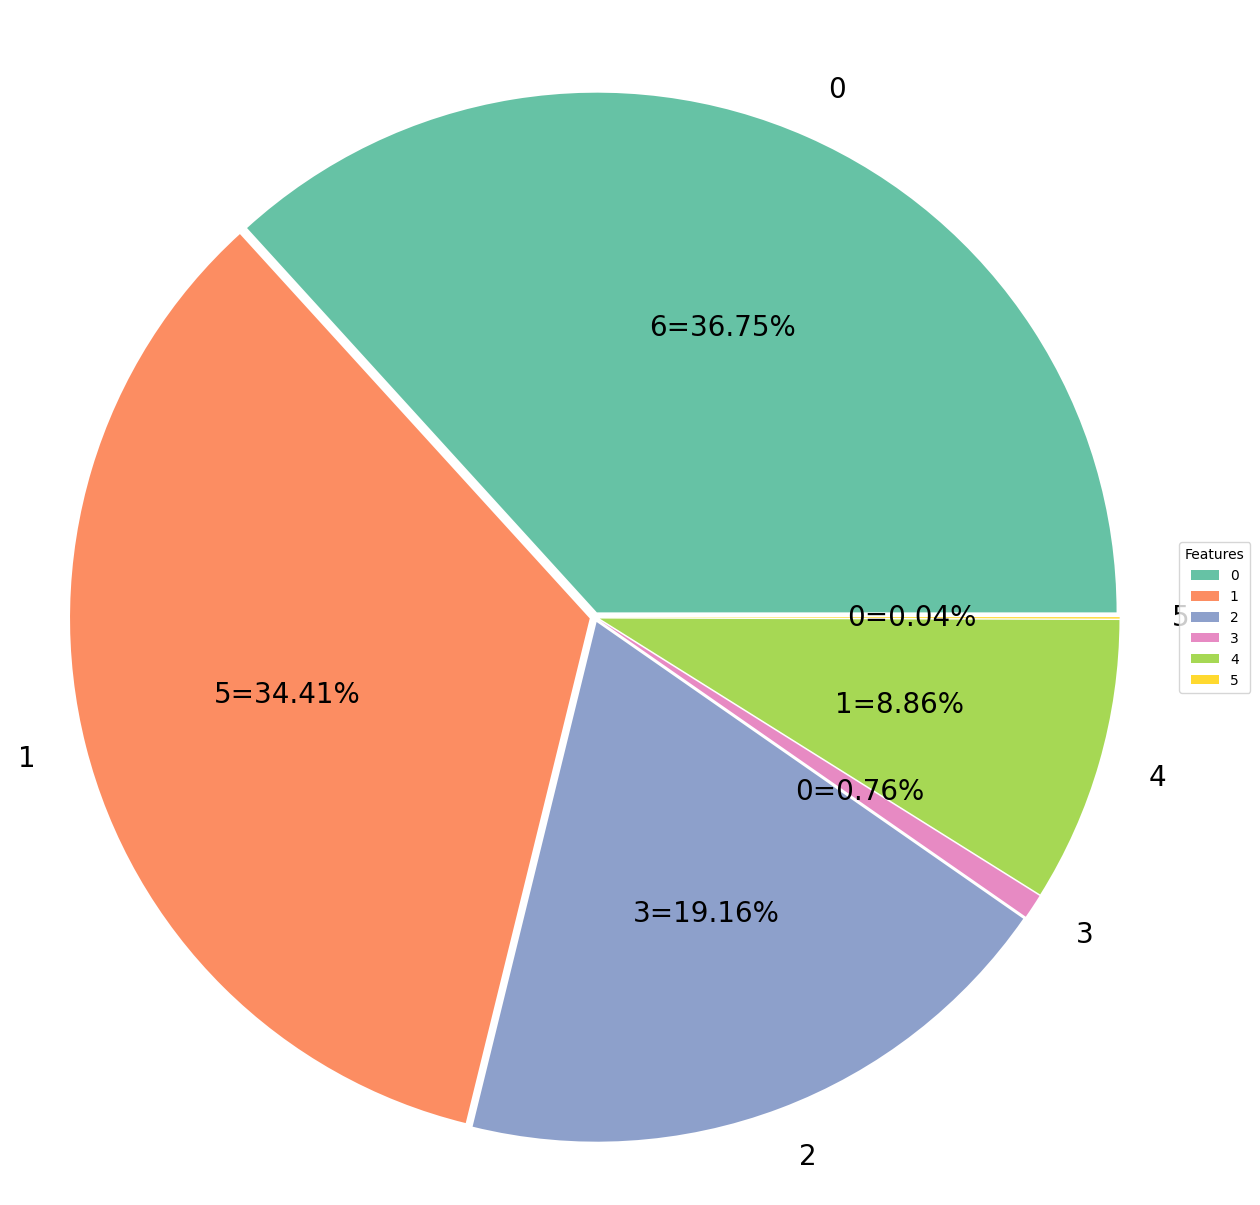

End of pie chart of supplement_clinical_data


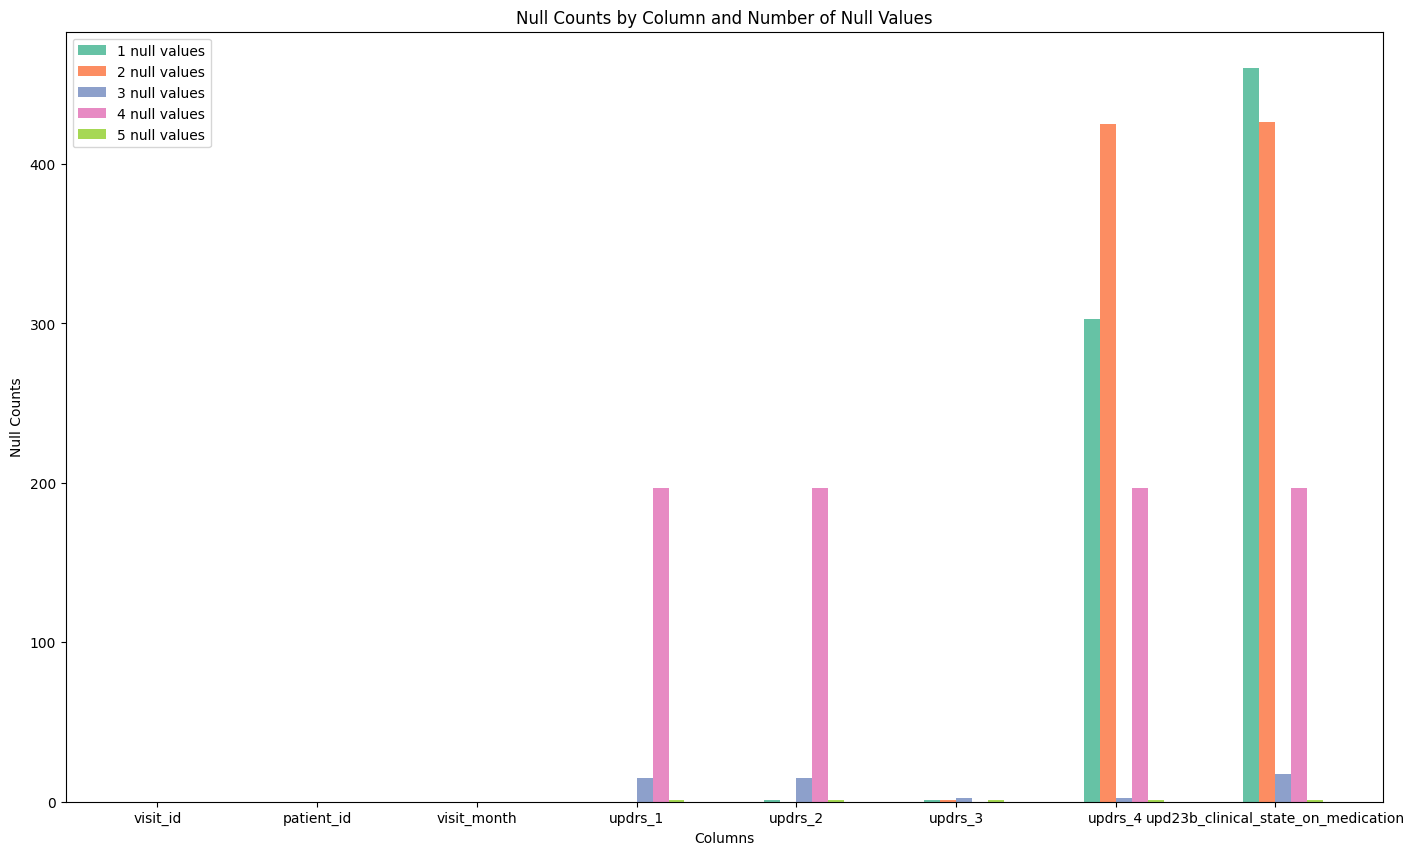

In [18]:
j,k =null_count_visuallisation(supplement_clinical_data)

Since deleting the null value rows would cause a loss of significance in the data,
different methods such domain reduction could be used to do it this could target the 
specific columns which are required to be included training data for the model to perform
while ignoring the others which could be the ones with high null values(thi hypothesis needs 
to be tested),or perform a multivariate imputation method.


Goetz, C.G., Luo, S., Wang, L., Tilley, B.C., LaPelle, N.R. and Stebbins, G.T. (2015). Handling missing values in the MDS-UPDRS. Movement Disorders, 30(12), pp.1632–1638. doi:https://doi.org/10.1002/mds.26153.

KumarDey, P. and Mukhopadhay, S. (2013). Modified Deviation Approach to Deal with Missing Attribute Values in Data Mining with different Percentage of Missing Values. International Journal of Computer Applications, 73(5), pp.1–7. doi:https://doi.org/10.5120/12734-9634.
‌

In [19]:
'''Below is some code to decipher if we should use the null values or not and also
return an imputed dataset to compensate for them
however I will add some feature engineering code to check which features
contribute to what we require from this dataset and by how much'''

class data_preprocessing:

    '''Initialise the data'''
    
    def __init__(self,df):
        self.df =df

    
    '''Lets create a null value pipeline function to visualize the data set w.r.t to the visit_id for 
    all the dataframes'''

    def null_count_visuallisation(df):

        # # Create a unique name for each dataframe in the data
        # df_name='nullCount_'+df.name+'_by_visit_id'

        # create a DataFrame and assign it to a variable with the same name
        globals()['df'] = df

        # get the name of the DataFrame
        df_name=([var for var in globals() if globals()[var] is df][0])

        print('The name of the DataFrame is {}'.format(df_name))



        # This extracts the null numbers per row from the dataframe and puts it in a new column
        df['nullCount']=train_clinical_data.isnull().sum(axis=1)

        # Now lets look at the null values by grouping them 
        null_count = df.groupby('nullCount')['visit_id'].count().to_dict()
        print('The null count for {} is {}'.format(df_name, null_count))


        # Now let's make the structure of the plots 
        # This would be a single row and column plot 
        fig,axs=plt.subplots(figsize=(15,15))
        
        # create the pie chart 
        _=axs.pie(
            x=list(null_count.values()),
            autopct=lambda x: "{:,.0f}={:.2f}%".format(x*sum(null_count)/100,x),
            explode=[0.01]* len(null_count.keys()),
            labels=null_count.keys(),
            colors=sns.color_palette('Set2')[0:len(null_count.keys())],
            textprops={'fontsize': 20}

        ) 
        print('This is the pie chart')

        axs.set_title('Null Count of {}'.format(null_count),color='White',fontsize=20)        
        # axs=axs.flatten()

        # Add a legend 
        axs.legend(title='Features',loc='center left',bbox_to_anchor=(1,0,0.5,1))

        axs.axis('equal')
        axs.set_ylabel('')

        plt.show()

        print('End of pie chart')


        return null_count

    def data_pipeline(self):
        """
        This function takes a dataset and identifies string or object data types which need to be encoded,
        and leaves the other data types which are numerical as is.
        """
        df=self.df
        
        # Identify string or object data types
        cat_vars = df.select_dtypes(include='object').columns.tolist()

        # If there are no string or object data types, print a message and return the original dataframe
        if len(cat_vars) == 0:
            print('No string or object data types found.')
            return df
        

        # If there are string or object data types, encode them using LabelEncoder or OneHotEncoder
        for col in cat_vars:
            
            # Check if column has a unique identifier
            if len(df[col].unique()) == df[col].count():
                print(f"Skipping column {col} as it has a unique identifier.")
                continue
            if len(df[col].unique()) > 2:
                # If number of unique values is greater than 2, use one-hot encoding
                ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
                encoded = ohe.fit_transform(df[[col]].fillna('Unknown'))
                new_cols = [f"{col}_{cat}" for cat in ohe.categories_[0]]
                df[new_cols] = encoded
                df.drop(col, axis=1, inplace=True)
            else:
                # If number of unique values is 2 or less, use label encoding
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].fillna('Unknown'))

        # Return the processed dataframe
        return df


    def nan_pipeline(self):
        """
        This function takes a dataset and decides how to handle NaN values without affecting the statistical 
        properties too much, and gives a suggested output with a statement and the new dataframe.
        """
        df=self.data_pipeline()

        
        # Identify columns with NaN values
        nan_cols = df.columns[df.isna().any()].tolist()

        # If there are no NaN values, print a message and return the original dataframe
        if len(nan_cols) == 0:
            print('No NaN values found.')
            return df

        # If there are NaN values, impute them using IterativeImputer
        imputer = IterativeImputer(max_iter=100, random_state=342)
        imputed = imputer.fit_transform(df)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)

        # Check for normality of each variable before and after imputation
        normality_tests_before = []
        for col in df.columns:
            # Check if column has numeric data type
            if not np.issubdtype(df[col].dtype, np.number):
                continue
            normal_test, p = normaltest(df[col].dropna())
            normality_tests_before.append((col, normal_test, p))
        normality_df_before = pd.DataFrame(normality_tests_before, columns=['column', 'normal_test_before', 'p_value_before'])

        normality_tests_after = []
        for col in df.columns:
            # Check if column has numeric data type
            if not np.issubdtype(df[col].dtype, np.number):
                continue
            normal_test, p = normaltest(df_imputed[col].dropna())
            normality_tests_after.append((col, normal_test, p))
        normality_df_after = pd.DataFrame(normality_tests_after, columns=['column', 'normal_test_after', 'p_value_after'])

        # Calculate the difference in normality before and after imputation
        normality_df = pd.merge(normality_df_before, normality_df_after, on='column')
        normality_df['normal_test_diff'] = normality_df['normal_test_before'] - normality_df['normal_test_after']

        # Suggest the best course of action based on the difference in normality before and after imputation
        if (normality_df['normal_test_diff'] < -1000).any():
            print('Imputed NaN values have greatly affected normality. Consider a different approach.')
        elif (normality_df['normal_test_diff'] < 0).any():
            print('Imputed NaN values have slightly affected normality. Proceed with caution.')
        else:
            print('Imputed NaN values have not affected normality significantly.')

        # Return the imputed dataframe
        return df_imputed


In [20]:
tcd=data_preprocessing(train_clinical_data)
scd=data_preprocessing(supplement_clinical_data)
tpep=data_preprocessing(train_peptides)
tpro=data_preprocessing(train_proteins)

In [24]:
'''Print out the new df'''
tcd_df=tcd.nan_pipeline()
scd_df=scd.nan_pipeline()
# tpep_df=tpep.nan_pipeline()
# tpro_df=tpro.nan_pipeline()

Skipping column visit_id as it has a unique identifier.
Imputed NaN values have slightly affected normality. Proceed with caution.
Skipping column visit_id as it has a unique identifier.
Imputed NaN values have slightly affected normality. Proceed with caution.


Mainly the below two datasets have missing nan values for which we will impute the columns:

In [26]:
tcd_df.head(5)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,nullCount,upd23b_clinical_state_on_medication_Off,upd23b_clinical_state_on_medication_On,upd23b_clinical_state_on_medication_Unknown
0,550.0,55.0,0.0,10.0,6.0,15.0,0.887585,2.0,0.0,0.0,1.0
1,553.0,55.0,3.0,10.0,7.0,25.0,0.894950,2.0,0.0,0.0,1.0
2,556.0,55.0,6.0,8.0,10.0,34.0,0.776773,2.0,0.0,0.0,1.0
3,559.0,55.0,9.0,8.0,9.0,30.0,0.000000,0.0,0.0,1.0,0.0
4,5512.0,55.0,12.0,10.0,10.0,41.0,0.000000,0.0,0.0,1.0,0.0


In [27]:
scd_df.head(5)

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,nullCount,upd23b_clinical_state_on_medication_Off,upd23b_clinical_state_on_medication_On,upd23b_clinical_state_on_medication_Unknown
0,350.0,35.0,0.0,5.000000,3.00000,16.0,0.00000,1.0,0.0,0.0,1.0
1,3536.0,35.0,36.0,6.000000,4.00000,20.0,0.00000,1.0,0.0,0.0,1.0
2,750.0,75.0,0.0,4.000000,6.00000,26.0,0.00000,1.0,0.0,0.0,1.0
3,7536.0,75.0,36.0,1.000000,8.00000,38.0,0.00000,0.0,0.0,1.0,0.0
4,1550.0,155.0,0.0,4.306827,1.42787,0.0,4.51142,4.0,0.0,0.0,1.0


In [ ]:
tcd_df=tcd_df.drop(columns=['upd23b_clinical_state_on_medication_Off','upd23b_clinical_state_on_medication_Unknown'])
